# Scalability Performance Plots

## Setup

In [1]:
plot_dir = "out"
fig_width = 12.0 # Width of a figure that spans 100% of the page width
fig_height = 8.0 # Height of a figure that spans 100% of the page width
def fig_size(scale=1.0, height=1.0):
    return (fig_width * scale, fig_height * scale * height)

In [2]:
import os
import functools
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import seaborn as sns
import colorsys
import matplotlib.colors as mcolors

In [3]:
sns.set_theme(palette='colorblind', color_codes=True)

sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.3)
plt.rcParams['figure.dpi'] = 72
#plt.rcParams['font.family'] = 'DejaVu Sans'

plt.rcParams['font.family'] = 'serif' # or 'sans-serif' or 'monospace'
plt.rcParams['font.serif'] = 'cmr10'
plt.rcParams['font.sans-serif'] = 'cmss10'
plt.rcParams['font.monospace'] = 'cmtt10'
plt.rcParams["axes.formatter.use_mathtext"] = True # to fix the minus signs

In [4]:
# Decorator to add optional output_pdf and show arguments to plot functions
def plot_d(func, save_dir):
    @functools.wraps(func)
    def wrapper(*args, output_pdf=None, dpi=None, show=True, **kwargs):
        res = func(*args, **kwargs)

        if output_pdf is not None:
            if dpi is None:
                plt.savefig(os.path.join(save_dir, output_pdf), bbox_inches='tight')
            else:
                plt.savefig(os.path.join(save_dir, output_pdf), bbox_inches='tight', dpi=dpi)
        if show:
            plt.show()
        plt.close()

        return res

    return wrapper

plot = functools.partial(plot_d, save_dir=plot_dir)

## Plotting

In [12]:
dfs = []
for in_file in [ f"out/scalability_results_{s}.csv" for s in ['a', 'b', 'c'] ]:
    df = pd.read_csv(in_file, index_col=0)
    df.reset_index(inplace=True)
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
df['traffic'] = df['traffic'].replace({
    '--traffic none': 'None',
    '--traffic point_to_point_eos --traffic-scale 1': 'Small',
    '--traffic point_to_point_eos --traffic-scale 100': 'Large',
    '--traffic point_to_point_eos --traffic-scale 10000': 'Largest',
}).astype('category')
df['scenario'] = df['scenario'].replace({
    'walker': 66,
    'walker_large': 1584,
}).astype(int)
df['walker_scale'] = df['walker_scale'].astype(int)
df['num_nodes'] = df['scenario'] * df['walker_scale']
df = df.drop(columns=['walker_scale', 'scenario'])
#df['real_time'] = df['real_time'].apply(lambda x: f"00:0{x}" if len(x) == 7 else f"00:{x}")
df['real_time'] = df['real_time'].apply(lambda x: f"00:{x}" if '.' in x else x)
df['real_time'] = pd.to_timedelta(df['real_time'])
df['real_time_s'] = df['real_time'].dt.total_seconds()
df['real_time_speedup'] = 6000.0 / df['real_time_s']
df['max_memory'] = df['max_memory'].astype(int)
df['max_memory_mb'] = df['max_memory'] / 1024
df['max_memory_gb'] = df['max_memory_mb'] / 1024
df

/tmp/ipykernel_23627/330869531.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['scenario'] = df['scenario'].replace({


,traffic,real_time,max_memory,num_nodes,real_time_s,real_time_speedup,max_memory_mb,max_memory_gb
0,None,0 days 00:00:04.310000,238052,132,4.31,1392.111369,232.472656,0.227024
1,None,0 days 00:00:04.380000,235696,66,4.38,1369.863014,230.171875,0.224777
2,None,0 days 00:00:04.620000,241332,264,4.62,1298.701299,235.675781,0.230152
3,None,0 days 00:00:04.640000,248188,528,4.64,1293.103448,242.371094,0.236691
4,None,0 days 00:00:05.160000,267664,1056,5.16,1162.790698,261.390625,0.255264
...,...,...,...,...,...,...,...,...
127,Largest,0 days 01:59:28,1584220,3168,7168.00,0.837054,1547.089844,1.510830
128,Largest,0 days 02:33:39,1316000,6336,9219.00,0.650830,1285.156250,1.255035
129,Largest,0 days 06:01:49,1904976,25344,21709.00,0.276383,1860.328125,1.816727
130,Largest,0 days 03:29:44,1467944,12672,12584.00,0.476796,1433.539062,1.399940


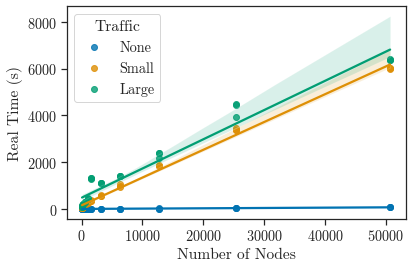

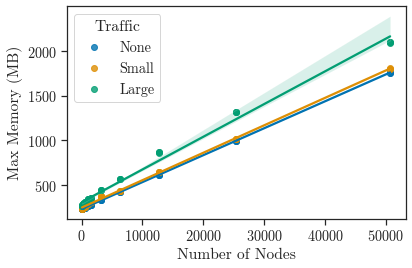

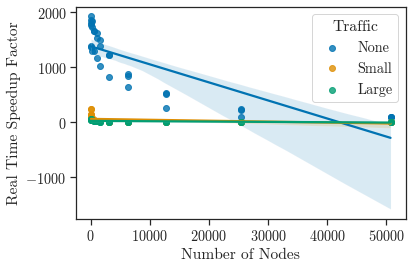

In [14]:
@plot
def plot_performance(df, y='real_time_s', ylabel='Real Time (s)', loc='upper center', traffics=None):
    traffics = traffics or ['None', 'Small', 'Large']

    fig, ax = plt.subplots(figsize=fig_size(0.5, 1.0))

    for traffic in traffics:
        traffic_df = df[df['traffic'] == traffic]
        sns.regplot(
            data=traffic_df,
            x='num_nodes',
            y=y,
            label=traffic,
            color=sns.color_palette()[traffics.index(traffic)],
            ax=ax,
            #order=2,
        )

    #ax.set_xscale('log')
    #ax.set_yscale('log' if not memory else 'linear')

    ax.set_xlabel('Number of Nodes')
    ax.set_ylabel(ylabel)
    ax.legend(title='Traffic', loc=loc)

    plt.tight_layout()

plot_performance(df, loc='upper left', output_pdf='performance-time.pdf')
plot_performance(df, y='max_memory_mb', ylabel='Max Memory (MB)', loc='upper left', output_pdf='performance-memory.pdf')
plot_performance(df, y='real_time_speedup', ylabel='Real Time Speedup Factor', loc='upper right')

In [16]:
df.groupby('traffic')['max_memory_mb'].max()

/tmp/ipykernel_23627/3884392241.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('traffic')['max_memory_mb'].max()


traffic
Large      2098.808594
Largest    2686.710938
None       1759.023438
Small      1808.253906
Name: max_memory_mb, dtype: float64

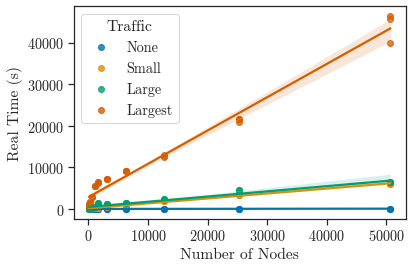

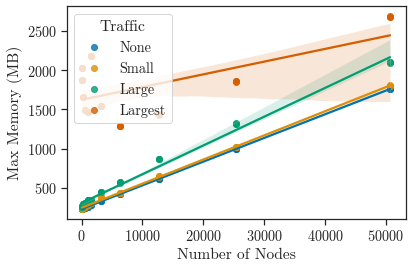

In [15]:
plot_performance(df, loc='upper left', traffics=['None', 'Small', 'Large', 'Largest'])
plot_performance(df, y='max_memory_mb', ylabel='Max Memory (MB)', loc='upper left', traffics=['None', 'Small', 'Large', 'Largest'])